In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from collections import Counter

from tqdm import tqdm, trange, tqdm_notebook

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.init import kaiming_uniform as init_ku
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score, classification_report

from feng.data import load_pseudo, load_iedb
from feng.models import ResNet

In [2]:
df = pd.read_csv("/Users/vdn/Downloads/epitope_table_export_1524474677.csv", skiprows=1)
print(len(df))
df.head()

78397


,Epitope ID,Object Type,Description,Epitope Modified Residue(s),Epitope Modification(s),Starting Position,Ending Position,Non-peptidic epitope Accession,Epitope Synonyms,Antigen Name,...,Object Type.1,Description.1,Starting Position.1,Ending Position.1,Non-peptidic object Accession,Synonyms,Antigen Name.1,Parent Protein.1,Organism Name.1,Parent Organism.1
0,10,Linear peptide,AAAAAIFVI,NaN,NaN,296.0,304.0,NaN,NaN,MHC class I related protein A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,Linear peptide,AAAAALDKKQRNFDKILA,NaN,NaN,1437.0,1454.0,NaN,NaN,Myosin-7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,Linear peptide,AAAAKLAGLVFPQPPAPIAV,NaN,NaN,14.0,33.0,NaN,NaN,hypothetical protein Rv3878 - Mycobacterium tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28,Linear peptide,AAADVYAKTDQSLGTSLSQY,NaN,NaN,74.0,93.0,NaN,NaN,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29,Linear peptide,AAAEGVGKDNKLSVLLFTTQ,NaN,NaN,91.0,110.0,NaN,NaN,putative M2L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Counter(map(len, df["Description"]))

Counter({3: 3,
         4: 1,
         5: 7,
         6: 86,
         7: 28,
         8: 361,
         9: 8819,
         10: 4714,
         11: 513,
         12: 2152,
         13: 660,
         14: 1174,
         15: 42728,
         16: 1688,
         17: 2414,
         18: 4250,
         19: 727,
         20: 5917,
         21: 464,
         22: 178,
         23: 155,
         24: 152,
         25: 311,
         26: 116,
         27: 132,
         28: 49,
         29: 41,
         30: 160,
         31: 60,
         32: 55,
         33: 37,
         34: 28,
         35: 37,
         36: 28,
         37: 22,
         38: 11,
         39: 8,
         40: 9,
         41: 11,
         42: 6,
         43: 6,
         44: 6,
         45: 22,
         46: 4,
         47: 3,
         48: 3,
         49: 4,
         50: 7,
         51: 2,
         52: 1,
         53: 3,
         54: 1,
         55: 3,
         57: 1,
         58: 1,
         60: 1,
         70: 1,
         71: 1,
         72: 

# Load the immunogenicity data

Counter({1: 6148, 0: 4854})
Counter({9: 6733, 10: 2347, 8: 1100, 11: 822})


array([<matplotlib.axes._subplots.AxesSubplot object at 0x112b7a7b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x113659ac8>], dtype=object)

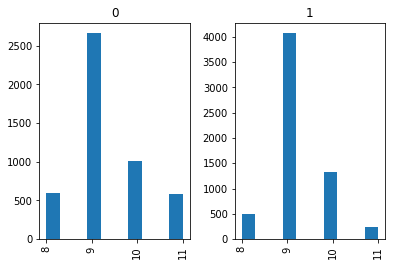

In [3]:
df = pd.read_csv("./immunogen/imm_classif.txt").iloc[:, 0:3]

print(Counter(df["Immunogenicity"]))
print(Counter(df["Length"]))

df.hist("Length", "Immunogenicity")

# Make dataset to feed into the network

# Make additional dataset with all combinations of HLAs per each peptide

In [4]:
pseudo = pd.read_csv("./data/pseudoseqs_hs.csv")
# Remove HLA-E because they are redundant here
pseudo = pseudo.loc[~pseudo["mhc"].str.contains("E"), :]
df.columns = ["sequence", "meas", "length"]
df["mhc"] = pseudo["mhc"][10]
df["meas"] = np.where(df["meas"].values == 0, 50000, 1)
df.head()

,sequence,meas,length,mhc
0,KLEDLERDL,1,9,HLA-A02:12
1,DLMGYIPLV,1,9,HLA-A02:12
2,QTVTSTPVQGR,1,11,HLA-A02:12
3,TTVYPPSSTAK,1,11,HLA-A02:12
4,LITGRLQSL,1,9,HLA-A02:12


In [351]:
df.to_csv("immunogen/imm_clf.csv")

# Function for NN training

In [469]:
def train(n_epochs, model, optimizer, criterion, lr, train_dl, test_dl, y_test, verbose=True):
    optimizer = optimizer(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        for pep, label in train_dl:
            optimizer.zero_grad()
            y_pred = model(pep)
            loss = criterion(y_pred, label.float().view((-1, 1)))
            loss.backward()
            optimizer.step()

        if verbose:
            evaluate(model, test_dl, y_test, epoch, n_epochs)
                
                
def evaluate(model, test_dl, y_test, epoch=None, max_epoch=None):
    model.eval()
    y_pred = []
    for pep, label in test_dl:
        y_pred.append(model(pep).item)

    if epoch:
        if epoch+1 == max_epoch:
            print()
            print(classification_report(y_test.long(), np.where(np.vstack(y_pred) >= .5, 1, 0)))
        else:
            print(round(f1_score(y_test.long(), np.where(np.vstack(y_pred) >= .5, 1, 0)), 2), end=" ")
        
    return f1_score(y_test.long(), np.where(np.vstack(y_pred) >= .5, 1, 0))

# Baseline model: some dense networks from amino acid embeddings

In [487]:
embed_file = "./aa_models/w2v_9mers_3wind_20dim_norm.pkl"

pseudo_data = load_pseudo("./data/", embed_file)
aa_channels = list(pseudo_data.values())[0].shape[1]

immunogen_dataset = load_iedb("cnn", "./immunogen/imm_clf.csv", 
                    embed_file,
                    pseudo_data,
                    min_len=8, max_len=11)

immunogen_dataset = TensorDataset(immunogen_dataset.pep, immunogen_dataset.aff)

sss = StratifiedShuffleSplit(1, random_state=42, train_size=0.8, test_size=0.2)
for split in sss.split(immunogen_dataset, immunogen_labels):
    train_split = split[0]
    test_split = split[1]
    
X_train, y_train = immunogen_dataset[torch.from_numpy(train_split)]
X_test, y_test = immunogen_dataset[torch.from_numpy(test_split)]

X_train = X_train.view((X_train.size(0), -1))
X_test = X_test.view((X_test.size(0), -1))

Loading pseudosequences...
Number of pseudo MHC: 104
File: ./immunogen/imm_clf.csv
Loading the data...	Done in 0.07 s
  Source size:    11002
  #Unknown MHC:   0
  #Wrong lengths: 0
Creating embeddings...	Done in 0.15 s
Shape of the data:
  MHC embeddings:     (11002, 34, 20)
  peptide embeddings: (11002, 11, 20)
  binding affinities: (11002,)


In [348]:
BATCH_SIZE=16

train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False, num_workers=0)

layers = []
layers.append(nn.Dropout(.1))

layers.append(nn.Linear(X_train.size(1), 96))
init_ku(layers[-1].weight)
layers.append(nn.SELU())
layers.append(nn.Dropout(.3))

layers.append(nn.Linear(96, 1))
init_ku(layers[-1].weight)
layers.append(nn.Dropout(.3))
layers.append(nn.Sigmoid())

immunogen_model = nn.Sequential(*layers)
immunogen_model

Sequential(
  (0): Dropout(p=0.1)
  (1): Linear(in_features=110, out_features=96, bias=True)
  (2): SELU
  (3): Dropout(p=0.3)
  (4): Linear(in_features=96, out_features=1, bias=True)
  (5): Dropout(p=0.3)
  (6): Sigmoid()
)

In [349]:
N_EPOCHS=15
LR=0.002
optimizer = optim.RMSprop
criterion = nn.functional.binary_cross_entropy

train(N_EPOCHS, immunogen_model, optimizer, criterion, LR, train_data_loader, test_data_loader, y_test)
train(N_EPOCHS, immunogen_model, optimizer, criterion, LR/10, train_data_loader, test_data_loader, y_test)

0.81 0.79 0.82 0.82 0.83 0.82 0.84 0.83 0.84 0.84 0.83 0.84 0.85 0.83 
             precision    recall  f1-score   support

          0       0.81      0.75      0.78       971
          1       0.81      0.86      0.84      1230

avg / total       0.81      0.81      0.81      2201

0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 
             precision    recall  f1-score   support

          0       0.81      0.82      0.82       971
          1       0.86      0.85      0.85      1230

avg / total       0.84      0.84      0.84      2201



## Nested CV

In [488]:
scores = {"baseline": [], "transfer": []}

In [489]:
def make_model():
    layers = []
    layers.append(nn.Dropout(.1))

    layers.append(nn.Linear(X_train.size(1), 96))
    init_ku(layers[-1].weight)
    layers.append(nn.SELU())
    layers.append(nn.Dropout(.3))

    layers.append(nn.Linear(96, 1))
    init_ku(layers[-1].weight)
    layers.append(nn.Dropout(.3))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)


BATCH_SIZE=16
N_EPOCHS=15
LR=0.002
N_FOLDS=8

cv = StratifiedKFold(N_FOLDS, shuffle=True, random_state=42)
scores["baseline"] = []
for split in cv_outer.split(immunogen_dataset, immunogen_labels):
    train_split = split[0]
    test_split = split[1]
    
    X_train, y_train = immunogen_dataset[torch.from_numpy(train_split)]
    X_test, y_test = immunogen_dataset[torch.from_numpy(test_split)]
    
    X_train = X_train.view((X_train.size(0), -1))
    X_test = X_test.view((X_test.size(0), -1))
    
    train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False, num_workers=0)
    
    optimizer = optim.RMSprop
    criterion = nn.functional.binary_cross_entropy
    immunogen_model = make_model()

    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR, train_data_loader, test_data_loader, y_val, False)
    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR/10, train_data_loader, test_data_loader, y_val, False)
    print(round(evaluate(immunogen_model, test_data_loader, y_test), 2), end=" ")

    fin = evaluate(immunogen_model, test_data_loader, y_test)
    scores["baseline"].append(fin)

0.86 0.86 0.85 0.87 0.83 0.85 

# Run the model and obtain peptide embeddings for each dataset

In [490]:
embed_file = "./aa_models/w2v_9mers_3wind_20dim_norm.pkl"
# embed_file = "./aa_models/kidera.pkl"

pseudo_data = load_pseudo("./data/", embed_file)
aa_channels = list(pseudo_data.values())[0].shape[1]

dataset = load_iedb("cnn", "./immunogen/imm_clf.csv", 
                    embed_file,
                    pseudo_data,
                    min_len=8, max_len=11)

Loading pseudosequences...
Number of pseudo MHC: 104
File: ./immunogen/imm_clf.csv
Loading the data...	Done in 0.09 s
  Source size:    11002
  #Unknown MHC:   0
  #Wrong lengths: 0
Creating embeddings...	Done in 0.19 s
Shape of the data:
  MHC embeddings:     (11002, 34, 20)
  peptide embeddings: (11002, 11, 20)
  binding affinities: (11002,)


In [491]:
model = ResNet(64, 34, 11, 4, 4, aa_channels, 3, [128, 128], .2, .2, .2)
state_dict = torch.load("immunogen/model_wei_w2v20n_synth_e40_b32_mhc4_pep4_lin128-128_filters64_filters64.pt")
model.load_state_dict(state_dict)
model = model.eval()

In [425]:
pep_emb = model.get_embeddings(Variable(dataset[0][0].contiguous().view((1, aa_channels, -1))),
                               Variable(dataset[0][1].contiguous().view((1, aa_channels, -1))))
print(pep_emb[1].size())
print(pep_emb[2].size())

torch.Size([1, 704])
torch.Size([1, 128])


# Train a new model using embeddings as inputs

In [492]:
immunogen_raw = []
immunogen_labels = dataset.aff
for i in trange(len(dataset)):
    mhc, pep, length, aff = dataset[i]
    pep_emb = model.get_embeddings(Variable(mhc.contiguous().view((1, aa_channels, -1))),
                                   Variable(pep.contiguous().view((1, aa_channels, -1))))[1]
    immunogen_raw.append(pep_emb)

100%|██████████| 11002/11002 [01:02<00:00, 175.94it/s]


In [493]:
immunogen_dataset = torch.cat(immunogen_raw, 0)
print(immunogen_dataset.size())
immunogen_dataset = TensorDataset(immunogen_dataset, immunogen_labels)
print(immunogen_labels.sum())

sss = StratifiedShuffleSplit(1, random_state=42, train_size=0.8, test_size=0.2)
for split in sss.split(immunogen_dataset, immunogen_labels):
    train_split = split[0]
    test_split = split[1]
    
X_train, y_train = immunogen_dataset[torch.from_numpy(train_split)]
X_test, y_test = immunogen_dataset[torch.from_numpy(test_split)]

torch.Size([11002, 704])
6148.0


In [478]:
BATCH_SIZE=16

train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False, num_workers=0)

layers = []
layers.append(nn.Dropout(.4))

layers.append(nn.Linear(X_train.size(1), 32))
init_ku(layers[-1].weight)
layers.append(nn.SELU())
layers.append(nn.Dropout(.3))

layers.append(nn.Linear(32, 1))
init_ku(layers[-1].weight)
layers.append(nn.Dropout(.3))
layers.append(nn.Sigmoid())

immunogen_model = nn.Sequential(*layers)
immunogen_model

Sequential(
  (0): Dropout(p=0.4)
  (1): Linear(in_features=704, out_features=32, bias=True)
  (2): SELU
  (3): Dropout(p=0.3)
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Dropout(p=0.3)
  (6): Sigmoid()
)

In [480]:
N_EPOCHS=15
LR=0.002
optimizer = optim.RMSprop
criterion = nn.functional.binary_cross_entropy

train(N_EPOCHS, immunogen_model, optimizer, criterion, LR, train_data_loader, test_data_loader, y_test)
train(N_EPOCHS, immunogen_model, optimizer, criterion, LR/10, train_data_loader, test_data_loader, y_test)

0.85 0.85 0.85 0.85 0.85 0.85 0.86 0.85 0.86 0.85 0.85 0.86 0.86 
             precision    recall  f1-score   support

          0       0.85      0.75      0.80       971
          1       0.82      0.89      0.86      1230

avg / total       0.83      0.83      0.83      2201

0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.87 0.86 0.86 0.86 0.86 
             precision    recall  f1-score   support

          0       0.85      0.80      0.82       971
          1       0.85      0.89      0.87      1230

avg / total       0.85      0.85      0.85      2201



In [494]:
def make_model():
    layers = []
    layers.append(nn.Dropout(.4))

    layers.append(nn.Linear(X_train.size(1), 32))
    init_ku(layers[-1].weight)
    layers.append(nn.SELU())
    layers.append(nn.Dropout(.3))

    layers.append(nn.Linear(32, 1))
    init_ku(layers[-1].weight)
    layers.append(nn.Dropout(.3))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)


BATCH_SIZE=16
N_EPOCHS=15
LR=0.002
N_FOLDS=8

cv = StratifiedKFold(N_FOLDS, shuffle=True, random_state=42)
scores["transfer"] = []
for split in cv_outer.split(immunogen_dataset, immunogen_labels):
    train_split = split[0]
    test_split = split[1]
    
    X_train, y_train = immunogen_dataset[torch.from_numpy(train_split)]
    X_test, y_test = immunogen_dataset[torch.from_numpy(test_split)]
    
    X_train = X_train.view((X_train.size(0), -1))
    X_test = X_test.view((X_test.size(0), -1))
    
    train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False, num_workers=0)
    
    optimizer = optim.RMSprop
    criterion = nn.functional.binary_cross_entropy
    immunogen_model = make_model()

    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR, train_data_loader, test_data_loader, y_val, False)
    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR/10, train_data_loader, test_data_loader, y_val, False)
    print(round(evaluate(immunogen_model, test_data_loader, y_test), 2), end=" ")

    fin = evaluate(immunogen_model, test_data_loader, y_test)
    scores["transfer"].append(fin)

0.87 0.87 0.86 0.88 0.85 0.86 

Text(0.5,1,'transfer')

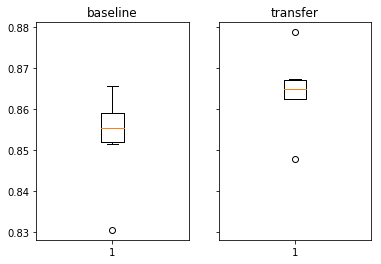

In [495]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, sharey=True)

_ = ax[0].boxplot(scores["baseline"])
ax[0].set_title("baseline")

_ = ax[1].boxplot(scores["transfer"])
ax[1].set_title("transfer")

In [502]:
def get_preds(model, test_dl, y_test, epoch=None, max_epoch=None):
    model.eval()
    y_pred = []
    for pep, label in test_dl:
        y_pred.append(model(Variable(pep, requires_grad=False)).data)

    if epoch:
        if epoch+1 == max_epoch:
            print()
            print(classification_report(y_test.long(), np.where(np.vstack(y_pred) >= .5, 1, 0)))
        else:
            print(round(f1_score(y_test.long(), np.where(np.vstack(y_pred) >= .5, 1, 0)), 2), end=" ")
        
    return np.vstack(y_pred)

In [ ]:
sss = StratifiedShuffleSplit(1, random_state=42, train_size=0.8, test_size=0.2)
for split in sss.split(immunogen_dataset, immunogen_labels):
    train_split = split[0]
    test_split = split[1]
    
X_train, y_train = immunogen_dataset[torch.from_numpy(train_split)]
X_test, y_test = immunogen_dataset[torch.from_numpy(test_split)]

BATCH_SIZE=16

train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False, num_workers=0)

In [531]:
model_list = []

In [532]:
for i in range(20):
    layers = []
    layers.append(nn.Dropout(.5))

    layers.append(nn.Linear(X_train.size(1), 64))
    init_ku(layers[-1].weight)
    layers.append(nn.SELU())
    layers.append(nn.Dropout(.5))

    layers.append(nn.Linear(64, 1))
    init_ku(layers[-1].weight)
    layers.append(nn.Dropout(.5))
    layers.append(nn.Sigmoid())

    immunogen_model = nn.Sequential(*layers)

    N_EPOCHS=20
    LR=0.002
    optimizer = optim.RMSprop
    criterion = nn.functional.binary_cross_entropy

    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR, train_data_loader, test_data_loader, y_test, verbose=False)
    train(N_EPOCHS, immunogen_model, optimizer, criterion, LR/10, train_data_loader, test_data_loader, y_test, verbose=False)
    model_list.append(immunogen_model)

In [533]:
final_preds = get_preds(model_list[0], test_data_loader, y_test)
for submodel in model_list[1:]:
    final_preds = np.hstack([final_preds, get_preds(submodel, test_data_loader, y_test)])

In [534]:
from scipy.stats import gmean

print(classification_report(y_test.long(), np.where(np.mean(final_preds, 1) >= .5, 1, 0)))
print(classification_report(y_test.long(), np.where(np.median(final_preds, 1) >= .5, 1, 0)))
print(classification_report(y_test.long(), np.where(gmean(final_preds, 1) >= .5, 1, 0)))

             precision    recall  f1-score   support

          0       0.81      0.78      0.79       971
          1       0.83      0.86      0.84      1230

avg / total       0.82      0.82      0.82      2201

             precision    recall  f1-score   support

          0       0.82      0.77      0.79       971
          1       0.83      0.86      0.85      1230

avg / total       0.82      0.82      0.82      2201

             precision    recall  f1-score   support

          0       0.81      0.78      0.79       971
          1       0.83      0.86      0.84      1230

avg / total       0.82      0.82      0.82      2201



In [ ]:
128*64 + 64*64

In [ ]:
700*32 + 32*32

In [430]:
220*96 + 96*64

27264